In [25]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
from tensorflow.keras.callbacks import LearningRateScheduler

# I. Data Loading

In [29]:
# Loading the Monthly Solar Data
file_path = 'solar_data.xlsx'
sheet_name = 'solarbymonth'

# Read the Excel sheet into a Pandas DataFrame
monthly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # Ensure the 'Month' column is in datetime format
months = monthly_data['Month']
utility_gen = monthly_data['Utility Scale Generation']
small_gen = monthly_data['Small Scale Generation']
total_solar = monthly_data['Total Solar']

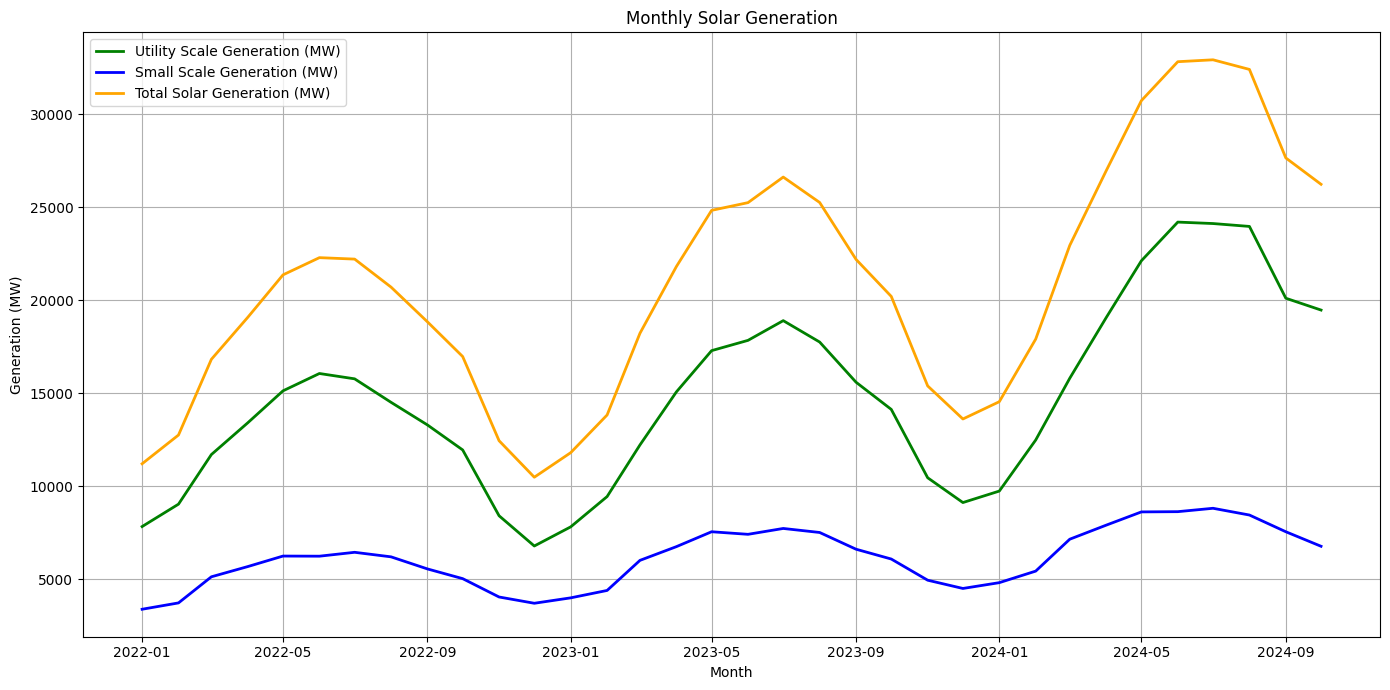

In [30]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(months, utility_gen, label='Utility Scale Generation (MW)', color='green', linewidth=2)
plt.plot(months, small_gen, label='Small Scale Generation (MW)', color='blue', linewidth=2)
plt.plot(months, total_solar, label='Total Solar Generation (MW)', color='orange', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Generation (MW)')
plt.title('Monthly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
# Loading the TSI Data
data_dir = 'tsi_monthly'

# Find all NetCDF files in the directory
file_paths = sorted(glob(os.path.join(data_dir, 'tsi_*.nc')))

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each file and load the data
for file_path in file_paths:
    # Open the NetCDF file
    dataset = xr.open_dataset(file_path)
    
    # Convert the dataset to a Pandas DataFrame and reset the index
    df = dataset.to_dataframe().reset_index()
    
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Append the DataFrame to the list
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Verify loading
print(all_data.head())

        time  bounds          TSI   TSI_UNC  time_bnds
0 2014-01-15       0  1361.692383  0.152830 2014-01-01
1 2014-01-15       1  1361.692383  0.152830 2014-02-01
2 2014-02-15       0  1361.590088  0.173391 2014-02-01
3 2014-02-15       1  1361.590088  0.173391 2014-03-01
4 2014-03-15       0  1362.293213  0.133309 2014-03-01


In [5]:
# Loading the Exponential Regression Data

def exp_func(x, a, b):
    return a * np.exp(b * x)

file_path = 'solar_data.xlsx'
sheet_name = 'capacitygrowth'

# Read the Excel sheet into a Pandas DataFrame
solar_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Sum the residential and commercial annual capacities into small scale
solar_data['Small Scale Annual'] = solar_data['Residential Annual'] + solar_data['Commercial Annual']
solar_data['Small Scale Cumul'] = solar_data['Residential Cumul'] + solar_data['Commercial Cumul']

# Extract relevant columns
years = solar_data['Year']
small_scale_annual = solar_data['Small Scale Annual']
utility_annual = solar_data['Utility Annual']
small_scale_cumul = solar_data['Small Scale Cumul']
utility_cumul = solar_data['Utility Cumul']

# Normalize the years to start from 0 for better numerical stability
normalized_years = years - years.min()

# Perform regression for small scale
params_small, _ = curve_fit(exp_func, normalized_years, small_scale_cumul, maxfev=10000)
small_scale_pred = exp_func(normalized_years, *params_small)

# Perform regression for utility
params_utility, _ = curve_fit(exp_func, normalized_years, utility_cumul, maxfev=10000)
utility_pred = exp_func(normalized_years, *params_utility)

# Verify loading
print(params_small)
print(params_utility)

[2.38570266e+03 2.05533322e-01]
[3.00547527e+03 2.30188812e-01]


# II. SANN Preliminary Testing

In [46]:
# Loading features
tsi_data = all_data.loc[monthly_data.index]
features_utility = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_utility[1]
                                }, index = monthly_data.index)

# Verify features loading
print(features_utility.head())

           TSI  Growth Factor
0  1361.692383       0.230189
1  1361.692383       0.230189
2  1361.590088       0.230189
3  1361.590088       0.230189
4  1362.293213       0.230189


In [59]:
utility_gen_values = utility_gen.values  # Convert to numpy array
scaler_y = MinMaxScaler()
utility_gen_scaled = scaler_y.fit_transform(utility_gen_values.reshape(-1, 1))

# Scale exogenous features
scaler_X = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features_utility)

In [60]:
# Create lagged features and targets, including exogenous variables
X, y = [], []
for i in range(seasonal_period, len(utility_gen_scaled) - seasonal_period + 1):
    # Lagged features (reversed seasonal window)
    lagged_features = utility_gen_scaled[i - seasonal_period:i][::-1]
    # Exogenous features
    exogenous_features = features_scaled[i]
    # Combine lagged and exogenous features
    combined_features = np.concatenate((lagged_features.flatten(), exogenous_features))
    X.append(combined_features)
    # Target values (next seasonal_period steps)
    y.append(utility_gen_scaled[i:i + seasonal_period])

X = np.array(X)
y = np.array(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
# Create lagged features and targets for the train set
X_train, y_train = [], []
for i in range(seasonal_period, len(train_scaled) - seasonal_period + 1):
    lagged_features = train_scaled[i - seasonal_period:i][::-1].flatten()
    exogenous_features = features_train_scaled[i]
    combined_features = np.concatenate((lagged_features, exogenous_features))
    X_train.append(combined_features)
    y_train.append(train_scaled[i:i + seasonal_period])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [61]:
# Define the neural network model
input_dim = X_train.shape[1]  # Includes lagged features + exogenous variables
model = Sequential()
model.add(Dense(hidden_nodes, input_dim=input_dim, activation='relu'))
model.add(Dense(seasonal_period, activation='linear'))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/150


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step - loss: 0.3724 - val_loss: 0.3459
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3585 - val_loss: 0.3324
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3449 - val_loss: 0.3192
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3317 - val_loss: 0.3063
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3186 - val_loss: 0.2936
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3058 - val_loss: 0.2811
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2933 - val_loss: 0.2690
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2812 - val_loss: 0.2573
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2693 - val_loss: 0.2458
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2578 - val_loss: 0.2347
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2465 - val_loss: 0.2238
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2356 - val_loss: 0.2133


In [62]:
# Evaluate on test data
y_pred_test = model.predict(X_test)

# Inverse transform predictions and targets
y_pred_test_inverse = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_test_inverse, y_pred_test_inverse, squared=False)
r2 = r2_score(y_test_inverse, y_pred_test_inverse)

print(f"RMSE on Test Data: {rmse:.2f}")
print(f"R² on Test Data: {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
RMSE on Test Data: 1259.83
R² on Test Data: 0.93


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


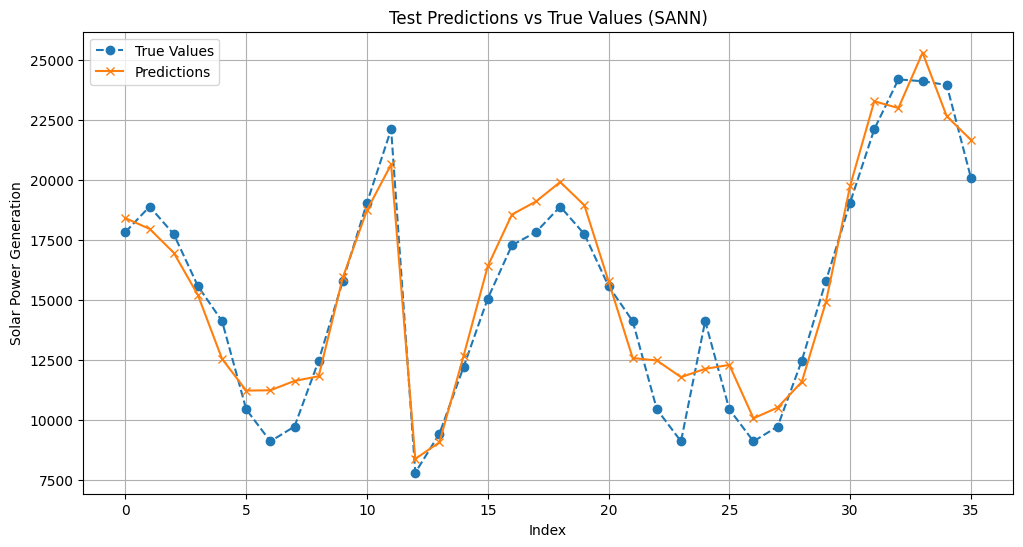

In [65]:
# Visualization: Test predictions vs real values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_inverse)), y_test_inverse, label='True Values', linestyle='--', marker='o')
plt.plot(range(len(y_pred_test_inverse)), y_pred_test_inverse, label='Predictions', linestyle='-', marker='x')

plt.xlabel('Index')
plt.ylabel('Solar Power Generation')
plt.title('Test Predictions vs True Values (SANN)')
plt.legend()
plt.grid(True)
plt.show()

# III. SANN Prediction

### i. Utility Scale

In [82]:
# Loading features
tsi_data = all_data.loc[monthly_data.index]
features_utility = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_utility[1]
                                }, index = monthly_data.index)

# Verify features loading
print(features_utility.head())

           TSI  Growth Factor
0  1361.692383       0.230189
1  1361.692383       0.230189
2  1361.590088       0.230189
3  1361.590088       0.230189
4  1362.293213       0.230189


In [83]:
utility_gen_values = utility_gen.values  # Convert to numpy array
scaler_y = MinMaxScaler()
utility_gen_scaled = scaler_y.fit_transform(utility_gen_values.reshape(-1, 1))

# Scale exogenous features
scaler_X = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features_utility)

# Parameters
seasonal_period = 12
hidden_nodes = 64
epochs = 150
batch_size = 16
future_steps = 12

In [84]:
# Create lagged features and targets, including exogenous variables
X_train, y_train = [], []
for i in range(seasonal_period, len(utility_gen_scaled) - seasonal_period + 1):
    # Lagged features (reversed seasonal window)
    lagged_features = utility_gen_scaled[i - seasonal_period:i][::-1]
    # Exogenous features
    exogenous_features = features_scaled[i]
    # Combine lagged and exogenous features
    combined_features = np.concatenate((lagged_features.flatten(), exogenous_features))
    X_train.append(combined_features)
    # Target values (next seasonal_period steps)
    y_train.append(utility_gen_scaled[i:i + seasonal_period])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Prepare input sequence for forecasting
input_seq_for_test = np.concatenate((utility_gen_scaled[-seasonal_period:][::-1].flatten(), features_scaled[-1]))
input_seq_for_test = input_seq_for_test.reshape(1, -1)

In [85]:
# Define the neural network model
input_dim = X_train.shape[1]  # Includes lagged features + exogenous variables
model = Sequential()
model.add(Dense(hidden_nodes, input_dim=input_dim, activation='relu'))
model.add(Dense(seasonal_period, activation='linear'))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/150


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - loss: 0.3332
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3181
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3035
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2894
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2758
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2627
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2501
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2379
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2262
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2149
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2040
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1934
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1833
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1736
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1643
Epoch 16/150
1/1 ━━━━━━━━━━━━━

In [86]:
# Forecast future values
iterations = future_steps // seasonal_period
forecasted_values = []

for _ in range(iterations + 1):
    next_forecasted_values = model.predict(input_seq_for_test)
    forecasted_values.extend(next_forecasted_values[0])
    # Update input sequence: Replace lagged part with forecast and keep exogenous features
    input_seq_for_test = np.concatenate((next_forecasted_values.flatten(), features_scaled[-1])).reshape(1, -1)

forecasted_values = forecasted_values[:future_steps]
forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


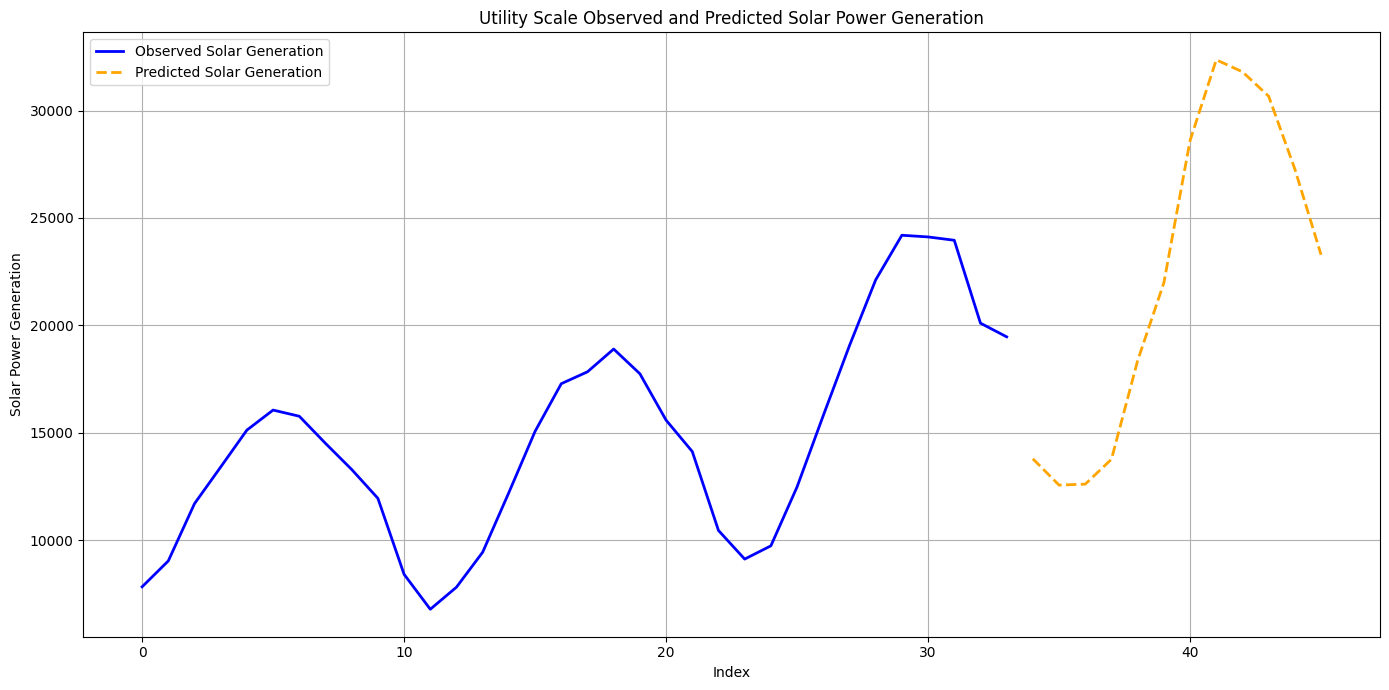

Root Mean Squared Error (RMSE): 5220.77
Mean Absolute Error (MAE): 4706.51


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [87]:
# Indices for observed and forecasted data
observed_indices = range(len(utility_gen_values))
forecast_indices = range(len(utility_gen_values), len(utility_gen_values) + len(forecasted_values))

# Plot the observed data and predictions
plt.figure(figsize=(14, 7))

# Observed data
plt.plot(observed_indices, utility_gen_values, label='Observed Solar Generation', color='blue', linewidth=2)

# Forecasted data
plt.plot(forecast_indices, forecasted_values, label='Predicted Solar Generation', color='orange', linestyle='--', linewidth=2)

# Plot formatting
plt.xlabel('Index')
plt.ylabel('Solar Power Generation')
plt.title('Utility Scale Observed and Predicted Solar Power Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Calculate statistics
rmse = mean_squared_error(utility_gen_values[-len(forecasted_values):], forecasted_values, squared=False)
mae = mean_absolute_error(utility_gen_values[-len(forecasted_values):], forecasted_values)
# Print the statistics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

### ii. Small Scale

In [75]:
tsi_data = all_data.loc[monthly_data.index]
features_small = pd.DataFrame({'TSI': tsi_data['TSI'],
                                 'Growth Factor': params_small[1]
                                }, index = monthly_data.index)
print(features_small.head())

           TSI  Growth Factor
0  1361.692383       0.205533
1  1361.692383       0.205533
2  1361.590088       0.205533
3  1361.590088       0.205533
4  1362.293213       0.205533


In [76]:
small_gen_values = small_gen.values  # Convert to numpy array
scaler_y = MinMaxScaler()
small_gen_scaled = scaler_y.fit_transform(small_gen_values.reshape(-1, 1))

# Scale exogenous features
scaler_X = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features_small)

# Parameters
seasonal_period = 12
hidden_nodes = 64
epochs = 150
batch_size = 16
future_steps = 12

In [77]:
# Create lagged features and targets, including exogenous variables
X_train, y_train = [], []
for i in range(seasonal_period, len(small_gen_scaled) - seasonal_period + 1):
    # Lagged features (reversed seasonal window)
    lagged_features = small_gen_scaled[i - seasonal_period:i][::-1]
    # Exogenous features
    exogenous_features = features_scaled[i]
    # Combine lagged and exogenous features
    combined_features = np.concatenate((lagged_features.flatten(), exogenous_features))
    X_train.append(combined_features)
    # Target values (next seasonal_period steps)
    y_train.append(small_gen_scaled[i:i + seasonal_period])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Prepare input sequence for forecasting
input_seq_for_test = np.concatenate((small_gen_scaled[-seasonal_period:][::-1].flatten(), features_scaled[-1]))
input_seq_for_test = input_seq_for_test.reshape(1, -1)

In [78]:
# Define the neural network model
input_dim = X_train.shape[1]  # Includes lagged features + exogenous variables
model = Sequential()
model.add(Dense(hidden_nodes, input_dim=input_dim, activation='relu'))
model.add(Dense(seasonal_period, activation='linear'))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/150


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - loss: 0.4178
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.4019
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3865
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3715
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3568
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3426
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3288
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3154
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3024
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2897
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2773
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2654
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2540
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2428
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2321
Epoch 16/150
1/1 ━━━━━━━━━━━━━

In [79]:
# Forecast future values
iterations = future_steps // seasonal_period
forecasted_values = []

for _ in range(iterations + 1):
    next_forecasted_values = model.predict(input_seq_for_test)
    forecasted_values.extend(next_forecasted_values[0])
    # Update input sequence: Replace lagged part with forecast and keep exogenous features
    input_seq_for_test = np.concatenate((next_forecasted_values.flatten(), features_scaled[-1])).reshape(1, -1)

forecasted_values = forecasted_values[:future_steps]
forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


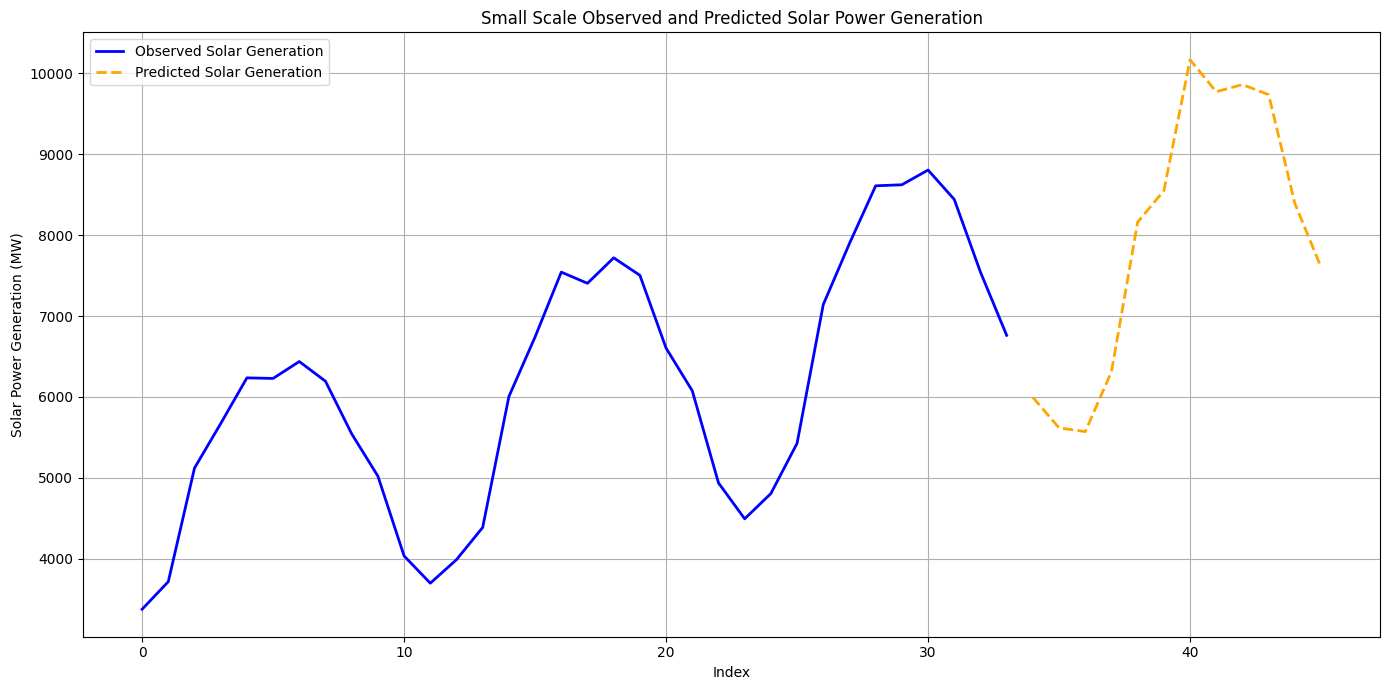

Root Mean Squared Error (RMSE): 1048.31
Mean Absolute Error (MAE): 1021.23


C:\Users\brayk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [81]:
# Indices for observed and forecasted data
observed_indices = range(len(small_gen_values))
forecast_indices = range(len(small_gen_values), len(small_gen_values) + len(forecasted_values))

# Plot the observed data and predictions
plt.figure(figsize=(14, 7))

# Observed data
plt.plot(observed_indices, small_gen_values, label='Observed Solar Generation', color='blue', linewidth=2)

# Forecasted data
plt.plot(forecast_indices, forecasted_values, label='Predicted Solar Generation', color='orange', linestyle='--', linewidth=2)

# Plot formatting
plt.xlabel('Index')
plt.ylabel('Solar Power Generation (MW)')
plt.title('Small Scale Observed and Predicted Solar Power Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Calculate statistics
rmse = mean_squared_error(small_gen_values[-len(forecasted_values):], forecasted_values, squared=False)
mae = mean_absolute_error(small_gen_values[-len(forecasted_values):], forecasted_values)
# Print the statistics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")